In [6]:
#This program provides an Interactive Signature Checker which works with SVM

#First we have to upload the file we want to use 

from pylab import *
import numpy as np
from os import listdir
from sklearn.svm import LinearSVC
import cv2
from PIL import Image
from sklearn import svm
import imagehash
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import linear_model



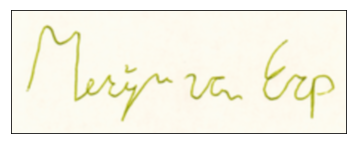

C:/Users/HP/Desktop/Dataset/dataset1/forge/02100001.png


In [11]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

#Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
img = cv2.imread(filename,1)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(filename)

In [9]:
genuine_image_filenames = listdir("C:/Users/HP/Desktop/Dataset/real")
forged_image_filenames = listdir("C:/Users/HP/Desktop/Dataset/forge")

In [18]:
genuine_image_paths = "C:/Users/HP/Desktop/Dataset/real"
forged_image_paths = "C:/Users/HP/Desktop/Dataset/forge"

genuine_image_features = [[] for x in range(12)]
forged_image_features = [[] for x in range(12)]

for name in genuine_image_filenames:
    sign = str(name.split('_')[0][-8:-5])
    signature_id=int(sign)
    genuine_image_features[signature_id - 1].append({"name": name})

for name in forged_image_filenames:
    sign = str(name.split('_')[0][-8:-5])
    signature_id=int(sign)
    forged_image_features[signature_id - 1].append({"name": name})


def preprocess_image(path, display=False):
    raw_image = cv2.imread(path)
    bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
    bw_image = 255 - bw_image

    if display:
        cv2.imshow("RGB to Gray", bw_image)
        cv2.waitKey()

    _, threshold_image = cv2.threshold(bw_image, 30, 255, 0)

    if display:
        cv2.imshow("Threshold", threshold_image)
        cv2.waitKey()

    return threshold_image


def get_contour_features(im, display=False):
  
    rect = cv2.minAreaRect(cv2.findNonZero(im))
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    w = np.linalg.norm(box[0] - box[1])
    h = np.linalg.norm(box[1] - box[2])

    aspect_ratio = max(w, h) / min(w, h)
    bounding_rect_area = w * h

    if display:
        image1 = cv2.drawContours(im.copy(), [box], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(image1, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    hull = cv2.convexHull(cv2.findNonZero(im))

    if display:
        convex_hull_image = cv2.drawContours(im.copy(), [hull], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(convex_hull_image, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    im2, contours, hierarchy = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if display:
        contour_image = cv2.drawContours(im.copy(), contours, -1, (120, 120, 120), 3)
        cv2.imshow("a", cv2.resize(contour_image, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    contour_area = 0
    for cnt in contours:
        contour_area += cv2.contourArea(cnt)
    hull_area = cv2.contourArea(hull)

    return aspect_ratio, bounding_rect_area, hull_area, contour_area

des_list = []

def sift(im, path, display=False):
    raw_image = cv2.imread(path)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(im, None)

    if display:
        cv2.drawKeypoints(im, kp, raw_image)
        cv2.imshow('sift_keypoints.jpg', cv2.resize(raw_image, (0, 0), fx=3, fy=3))
        cv2.waitKey()

    return (path, des)


cor = 0
wrong = 0

im_contour_features = []

for i in range(12):
    des_list = []
    for im in genuine_image_features[i]:
        image_path = genuine_image_paths + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))


    for im in forged_image_features[i]:
        image_path = forged_image_paths + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))

    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    k = 500
    voc, variance = kmeans(descriptors, k, 1)

    # Calculate the histogram of features
    im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k+4), "float32")
    for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
        words, distance = vq(des_list[i][1], voc)
        for w in words:
            im_features[i][w] += 1

        for j in range(4):
            im_features[i][k+j] = im_contour_features[i][j]

    
    # Scaling the words
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)

    train_genuine_features, test_genuine_features = im_features[0:3], im_features[3:5]

    train_forged_features, test_forged_features = im_features[5:8], im_features[8:10]

    #clf = linear_model.LogisticRegression(C=1e5)

    clf = LinearSVC()
    #clf = tree.DecisionTreeClassifier()
    #clf = tree.DecisionTreeRegressor()
    #clf = svm.SVC()
    clf.fit(np.concatenate((train_forged_features,train_genuine_features)), np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))



    #print("2" + str(clf.predict(test_genuine_features)))
    genuine_res = clf.predict(test_genuine_features)

    for res in genuine_res:
        if int(res) == 2:
            cor += 1
        else:
            wrong += 1

    #print("1" + str(clf.predict(test_forged_features)))
    forged_res = clf.predict(test_forged_features)

    for res in forged_res:
        if int(res) == 1:
            cor += 1
        else:
            wrong += 1

print(float(cor)/(cor+wrong))

IndexError: list index out of range